In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!unzip "/content/drive/MyDrive/Colab Notebooks/dataset.zip"

Archive:  /content/drive/MyDrive/Colab Notebooks/dataset.zip
   creating: dataset/
   creating: dataset/annotated_images/
  inflating: dataset/annotated_images/cat.0.png  
  inflating: dataset/annotated_images/cat.1.png  
  inflating: dataset/annotated_images/cat.10.png  
  inflating: dataset/annotated_images/cat.100.png  
  inflating: dataset/annotated_images/cat.101.png  
  inflating: dataset/annotated_images/cat.108.png  
  inflating: dataset/annotated_images/cat.11.png  
  inflating: dataset/annotated_images/cat.12.png  
  inflating: dataset/annotated_images/cat.126.png  
  inflating: dataset/annotated_images/cat.13.png  
  inflating: dataset/annotated_images/cat.14.png  
  inflating: dataset/annotated_images/cat.15.png  
  inflating: dataset/annotated_images/cat.152.png  
  inflating: dataset/annotated_images/cat.16.png  
  inflating: dataset/annotated_images/cat.17.png  
  inflating: dataset/annotated_images/cat.175.png  
  inflating: dataset/annotated_images/cat.18.png  
  infla

In [3]:
import tensorflow as tf
import os

DATA_DIR = '/content/dataset/'

IMAGE_DIR = os.path.join(DATA_DIR, 'original_images')
MASK_DIR = os.path.join(DATA_DIR, 'encoded_images')

In [4]:
image_filenames = sorted(os.listdir(IMAGE_DIR))
image_paths = [os.path.join(IMAGE_DIR, fname) for fname in image_filenames]

mask_filenames = sorted(os.listdir(MASK_DIR))
mask_paths = [os.path.join(MASK_DIR, fname) for fname in mask_filenames]


# Create the initial dataset of file path pairs
full_dataset = tf.data.Dataset.from_tensor_slices((image_paths, mask_paths))
print(image_paths[0])
print(mask_paths[0])

/content/dataset/original_images/cat.0.jpg
/content/dataset/encoded_images/cat.0.png


In [5]:
DATASET_SIZE = len(image_paths)
TRAIN_SIZE = int(0.8 * DATASET_SIZE) # 80% for training
VAL_SIZE = DATASET_SIZE - TRAIN_SIZE # 20% for validation


full_dataset = full_dataset.shuffle(buffer_size=DATASET_SIZE)

train_dataset = full_dataset.take(TRAIN_SIZE)
val_dataset = full_dataset.skip(TRAIN_SIZE)

print(f"Total examples: {DATASET_SIZE}")
print(f"Training examples: {len(train_dataset)}")
print(f"Validation examples: {len(val_dataset)}")

Total examples: 255
Training examples: 204
Validation examples: 51


In [6]:
IMG_HEIGHT = 128
IMG_WIDTH = 128

In [7]:
def load_and_preprocess(img_path, label_path):
    # 1. Read and decode the image
    img = tf.io.read_file(img_path)
    img = tf.image.decode_png(img, channels=3)
    img = tf.image.resize(img, [IMG_HEIGHT, IMG_WIDTH])
    # Normalize pixel values to be between 0 and 1
    img = tf.cast(img, tf.float32) / 255.0

    # 2. Read and decode the label (mask)
    label = tf.io.read_file(label_path)
    label = tf.image.decode_png(label, channels=1)
    # Use 'nearest' neighbor resizing for masks to avoid creating new class values
    label = tf.image.resize(label, [IMG_HEIGHT, IMG_WIDTH], method='nearest')

    return img, label

In [8]:
BATCH_SIZE = 16
BUFFER_SIZE = 200

In [9]:
train_batches = (
    train_dataset
    .map(load_and_preprocess, num_parallel_calls=tf.data.AUTOTUNE)
    .cache()  # Cache data for faster subsequent epochs
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE)
    .repeat() # Repeat the dataset indefinitely
    .prefetch(buffer_size=tf.data.AUTOTUNE) # Prepares the next batches while the current one is processed
)

In [10]:
val_batches = (
    val_dataset
    .map(load_and_preprocess, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(BATCH_SIZE)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)


--- Verifying a batch ---
Images batch shape: (16, 128, 128, 3)
Labels batch shape: (16, 128, 128, 1)


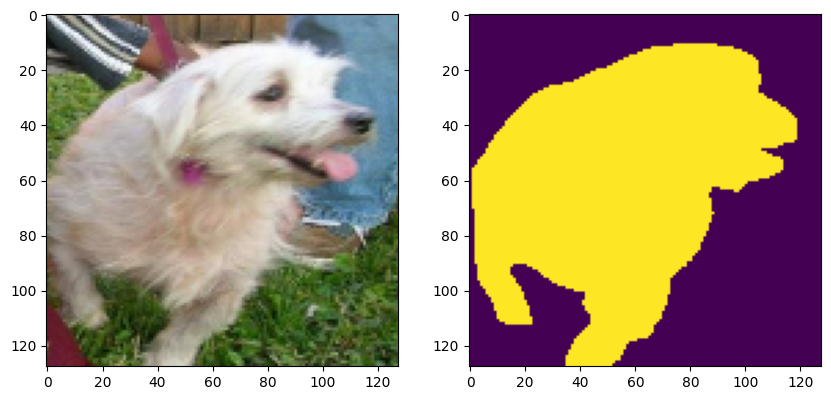

In [11]:
import matplotlib.pyplot as plt
temp_label =None
for images, labels in train_batches.take(1):
    print("\n--- Verifying a batch ---")
    print("Images batch shape:", images.shape)
    print("Labels batch shape:", labels.shape)

    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    indx = 0

    temp_label = labels[indx]
    axes[0].imshow(images[indx])
    axes[1].imshow(labels[indx],cmap='viridis')
    break
plt.show()



In [12]:
import numpy as np
color_value_list = set()
label_numpy = temp_label.numpy()
unique_values = np.unique(label_numpy)
print(unique_values)


for row in range(IMG_WIDTH):
    for col in range(IMG_HEIGHT):
        color_value = label_numpy[row, col][0]
        color_value_list.add(color_value)

print(color_value_list)

[0 2]
{np.uint8(0), np.uint8(2)}


## Build the U-Net Model


In [13]:
import tensorflow as tf
from tensorflow.keras import layers

def build_unet_with_mobilenet(input_shape, num_classes):
    """
    Builds a U-Net model using a pre-trained MobileNetV2 as the encoder.
    (Corrected Version)
    """

    base_model = tf.keras.applications.MobileNetV2(
        input_shape=input_shape,
        include_top=False,
        weights='imagenet'
    )


    layer_names = [
        'block_1_expand_relu',   # 64x64
        'block_3_expand_relu',   # 32x32
        'block_6_expand_relu',   # 16x16
        'block_13_expand_relu',  # 8x8
        'out_relu',              # Bottleneck: 4x4
    ]
    base_model_outputs = [base_model.get_layer(name).output for name in layer_names]

    # Create the feature extraction model (the encoder)
    encoder = tf.keras.Model(inputs=base_model.input, outputs=base_model_outputs, name="encoder")
    encoder.trainable = False



    #  Build the Decoder Path
    inputs = tf.keras.Input(shape=input_shape)
    skips = encoder(inputs)
    x = skips[-1]

    decoder_skips = reversed(skips[:-1])

    for i, skip in enumerate(decoder_skips):
        x = layers.Conv2DTranspose(filters=512 // (2**i), kernel_size=2, strides=2, padding='same')(x)
        x = layers.Concatenate()([x, skip])
        x = layers.Conv2D(filters=512 // (2**i), kernel_size=3, padding='same', activation='relu')(x)
        x = layers.Conv2D(filters=512 // (2**i), kernel_size=3, padding='same', activation='relu')(x)

    # It takes the 64x64 feature map and upsamples it to 128x128.
    outputs = layers.Conv2DTranspose(
        filters=num_classes,
        kernel_size=2,
        strides=2,
        padding='same',
        activation='softmax'  # Apply softmax directly here
    )(x)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)

    return model

In [14]:
NUM_CLASSES = 3
input_shape = (IMG_HEIGHT, IMG_WIDTH, 3)
model = build_unet_with_mobilenet(input_shape, NUM_CLASSES)
model.summary()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder             │ [(None, 64, 64,   │  2,257,984 │ input_layer_1[0]… │
│ (Functional)        │ 96), (None, 32,   │            │                   │
│                     │ 32, 144), (None,  │            │                   │
│                     │ 16, 16, 192),     │            │                   │
│                     │ (None, 8, 8,      │            │                   │
│                     │ 576), (None, 4,   │            │                   │
│                     │ 4, 1280)]         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose    │ (None, 8, 8, 512) │  2,621,952 │ encoder[0][4]     │
│ (Conv2DTranspose)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 8, 8,      │          0 │ conv2d_transpose… │
│ (Concatenate)       │ 1088)             │            │ encoder[0][3]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 8, 8, 512) │  5,014,016 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 8, 8, 512) │  2,359,808 │ conv2d[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_1  │ (None, 16, 16,    │    524,544 │ conv2d_1[0][0]    │
│ (Conv2DTranspose)   │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 16, 16,    │          0 │ conv2d_transpose… │
│ (Concatenate)       │ 448)              │            │ encoder[0][2]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 16, 16,    │  1,032,448 │ concatenate_1[0]… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 16, 16,    │    590,080 │ conv2d_2[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_2  │ (None, 32, 32,    │    131,200 │ conv2d_3[0][0]    │
│ (Conv2DTranspose)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (None, 32, 32,    │          0 │ conv2d_transpose… │
│ (Concatenate)       │ 272)              │            │ encoder[0][1]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 32, 32,    │    313,472 │ concatenate_2[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 32, 32,    │    147,584 │ conv2d_4[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_3  │ (None, 64, 64,    │     32,832 │ conv2d_5[0][0]    │
│ (Conv2DTranspose)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_3       │ (None, 64, 64,    │          0 │ conv2d_transpose

 Total params: 15,155,843 (57.81 MB)

 Trainable params: 12,897,859 (49.20 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [15]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [16]:
EPOCHS = 50
STEPS_PER_EPOCH = len(train_dataset) // BATCH_SIZE
print(STEPS_PER_EPOCH)

12


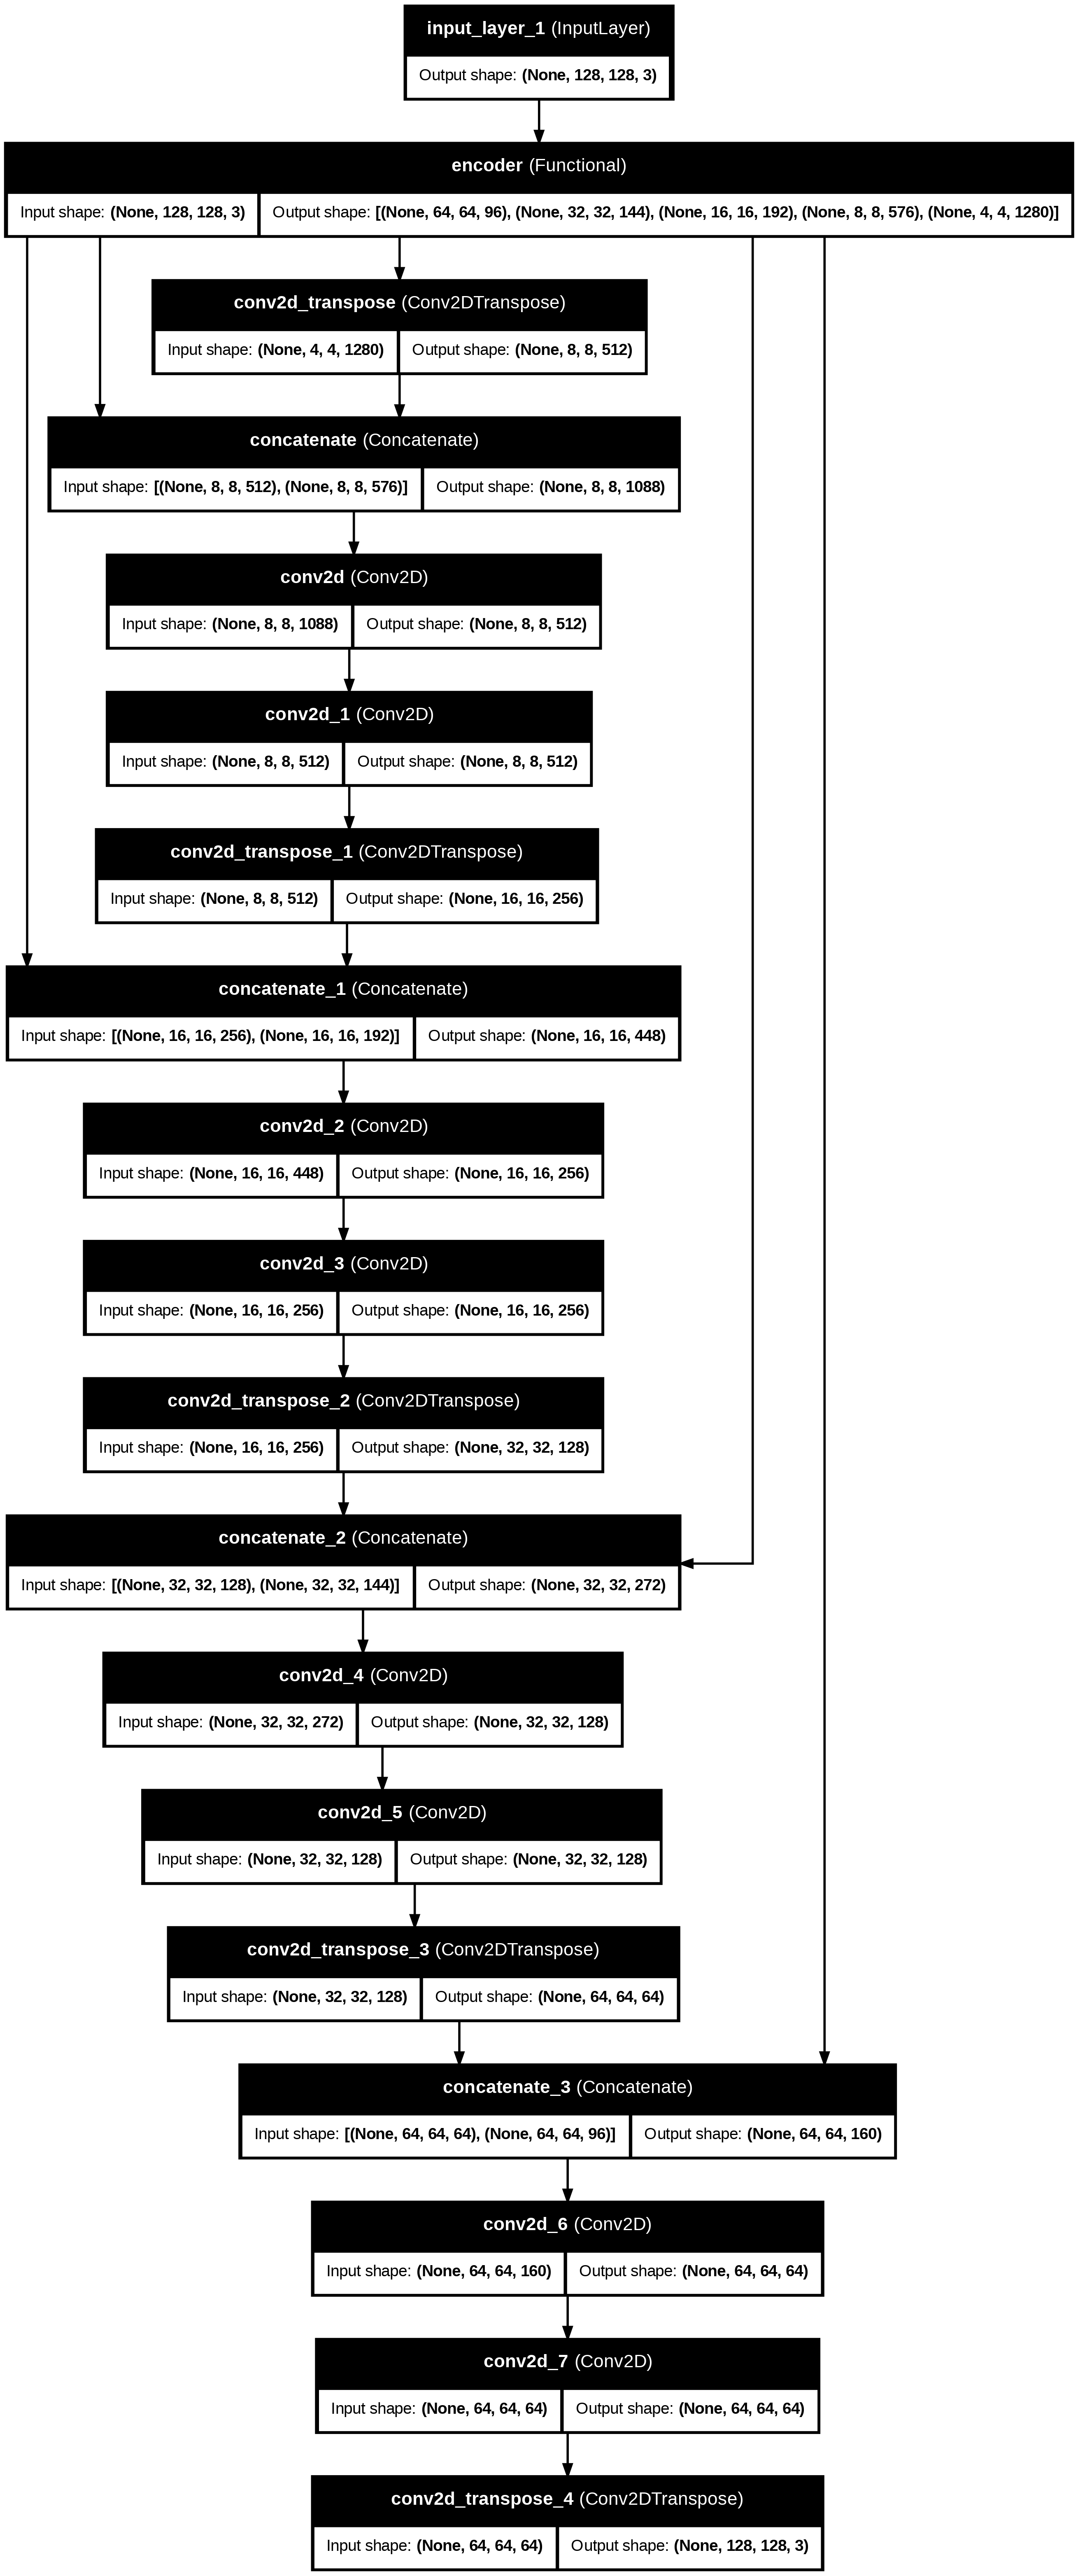

In [17]:
from tensorflow.keras.utils import plot_model

# pip install pydot
# Save model architecture as image
plot_model(model, to_file="tf_lr_model_architecture.png", show_shapes=True, show_layer_names=True)

In [18]:
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=3,
    min_lr=1e-5
)

history = model.fit(
    train_batches,
    epochs=EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    validation_data=val_batches,
    callbacks=[lr_scheduler]
)

Epoch 1/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 48s 2s/step - accuracy: 0.5017 - loss: 1.0557 - val_accuracy: 0.5639 - val_loss: 0.9018 - learning_rate: 0.0010
Epoch 2/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 18s 70ms/step - accuracy: 0.6010 - loss: 0.8412 - val_accuracy: 0.6471 - val_loss: 0.7212 - learning_rate: 0.0010
Epoch 3/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - accuracy: 0.5934 - loss: 0.9339 - val_accuracy: 0.5754 - val_loss: 0.8510 - learning_rate: 0.0010
Epoch 4/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 0.6087 - loss: 0.8274 - val_accuracy: 0.5754 - val_loss: 0.9030 - learning_rate: 0.0010
Epoch 5/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - accuracy: 0.6216 - loss: 0.7986 - val_accuracy: 0.7095 - val_loss: 0.6737 - learning_rate: 0.0010
Epoch 6/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 84ms/step - accuracy: 0.6858 - loss: 0.7016 - val_accuracy: 0.6698 - val_loss: 0.6908 - learning_rate: 0.0010
Epoch 7/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step - accuracy: 0.6968 - loss: 0.6289 - val_acc

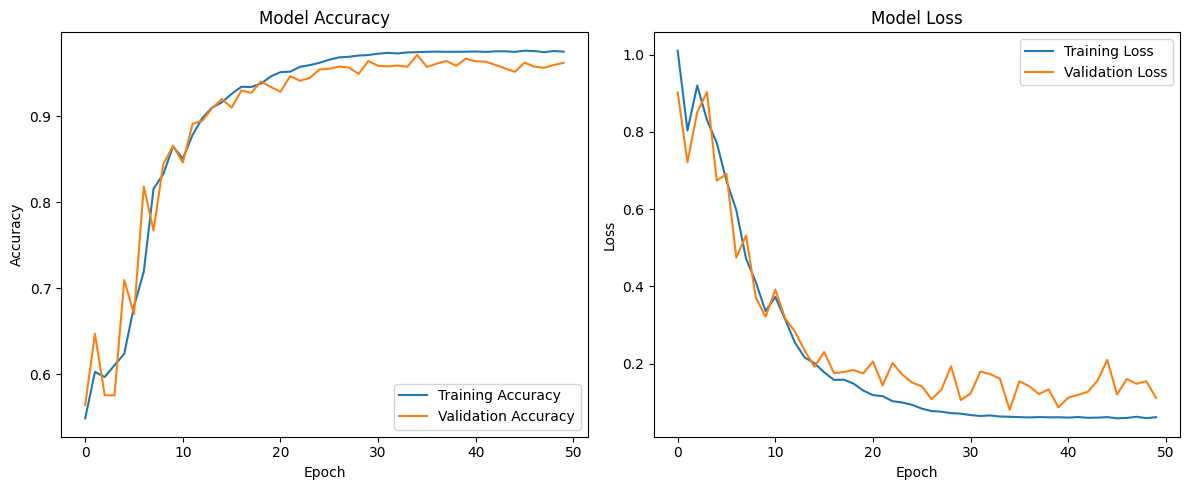

In [19]:
import matplotlib.pyplot as plt


has_validation_data = 'val_loss' in history.history


plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
if has_validation_data:
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
if has_validation_data:
    plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()

In [20]:
print("Evaluating model on the test set...")
loss, accuracy = model.evaluate(val_batches)

print(f"\nTest Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

Evaluating model on the test set...
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.9561 - loss: 0.1799

Test Loss: 0.2017
Test Accuracy: 0.9553


### Model Saving and Prediction

In [21]:
model.save('cat_dog_segmentation_unet.keras')

In [22]:
loaded_model = tf.keras.models.load_model('/content/cat_dog_segmentation_unet.keras')

In [23]:
import tensorflow as tf
import matplotlib.pyplot as plt

In [24]:
def model_predict(image_path, model):
    # This must be IDENTICAL to your training preprocessing
    img = tf.io.read_file(image_path)
    img = tf.image.decode_png(img, channels=3)
    img = tf.image.resize(img, [IMG_HEIGHT, IMG_WIDTH])
    img_normalized = tf.cast(img, tf.float32) / 255.0


    img_batch = tf.expand_dims(img_normalized, axis=0)

    # Predict
    predicted_masks = model.predict(img_batch)
    return predicted_masks , img


In [25]:
def predict_and_visualize(image_path, model):


    predicted_masks,img = model_predict(image_path, model)

    # The output is (1, H, W, num_classes).
    #  We take the argmax along the
    # class axis to get the final mask (1, H, W).
    pred_mask = tf.argmax(predicted_masks, axis=-1)

    # Remove the batch dimension to get a displayable image (H, W)
    pred_mask = pred_mask[0]
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.title("Input Image")
    # Display the original, un-normalized image
    plt.imshow(tf.keras.utils.array_to_img(img))
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.title("Predicted Mask")
    plt.imshow(pred_mask)
    plt.axis('off')

    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step


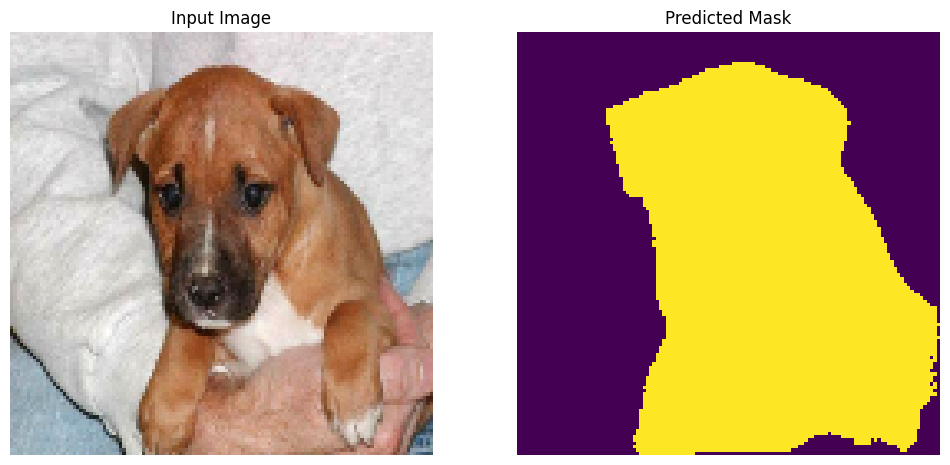

In [26]:
test_path = "/content/dataset/original_images/dog.33.jpg"

predict_and_visualize(test_path, loaded_model)

In [27]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

def predict_and_show_all_masks(image_path, model, class_encodings):
    """
    Loads an image, gets a prediction, and displays the probability
    mask for every individual class.
    """
    predicted_masks,img = model_predict(image_path, model)


    # --- 3. Visualize the Input and All Masks ---
    num_classes = model.output_shape[-1]

    # Create a figure to display the results
    # We need 1 spot for the input image + num_classes spots for the masks
    plt.figure(figsize=(15, 4 * (num_classes // 3 + 1)))

    # Plot the input image
    plt.subplot(2, 3, 1)
    plt.title("Input Image")
    plt.imshow(tf.keras.utils.array_to_img(img))
    plt.axis('off')

    # Loop through each class and plot its probability mask
    for i in range(num_classes):
        # Extract the mask for the i-th class
        class_mask = predicted_masks[0, :, :, i]

        # Get the class name from our encodings dictionary
        # JSON keys are strings, so we convert the index `i` to a string
        class_name = class_encodings.get(str(i), f"Class {i}")

        plt.subplot(2, 3, i + 2)
        plt.title(f"Mask: {class_name}")
        # Display the mask as a heatmap. 'viridis' is a good colormap for this.
        plt.imshow(class_mask, cmap='viridis')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


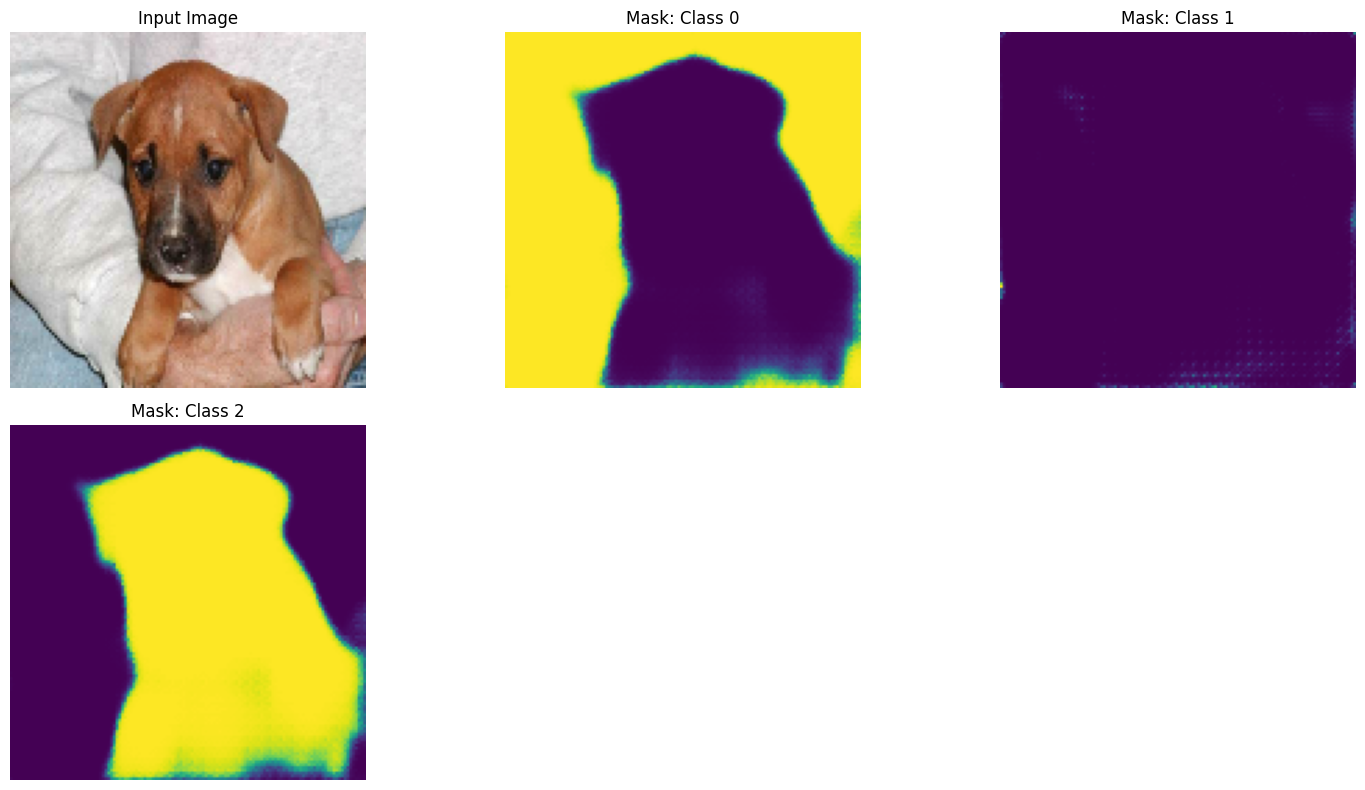

In [28]:
generic_encodings = {str(i): f"Class {i}" for i in range(NUM_CLASSES)}

predict_and_show_all_masks(test_path, loaded_model, generic_encodings)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


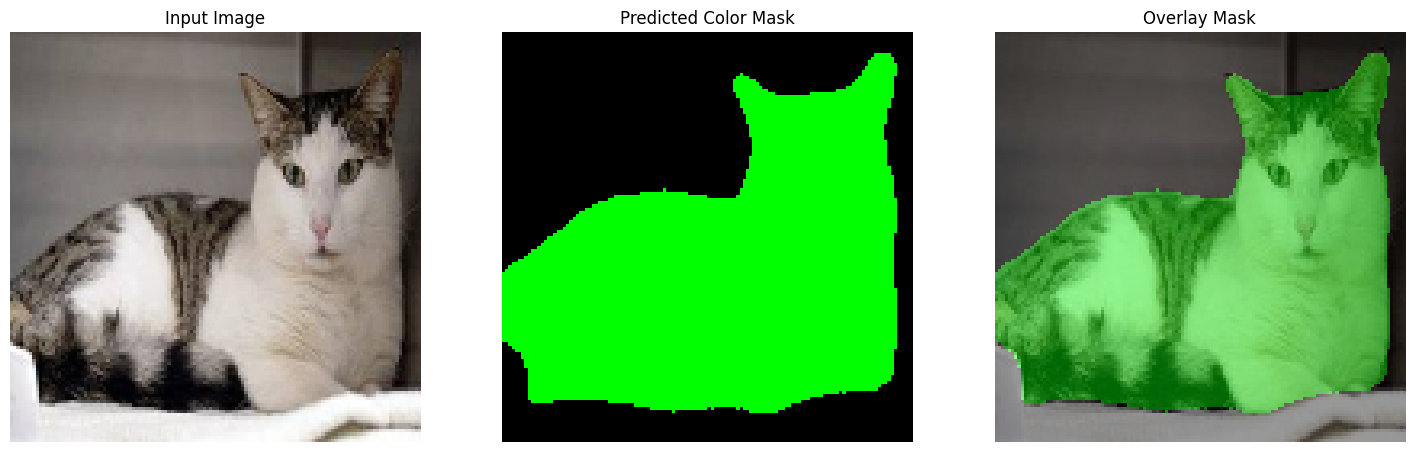

In [32]:
import numpy as np
import cv2

# 1. Define a color for each of your 5 classes (0 to 4)
COLOR_MAP = np.array([
    [0, 0, 0],       # Class 0: Black (e.g., background)
    [0, 255, 0],     # Class 1: Green
    [255, 0, 0]     # Class 2: Red
], dtype=np.uint8)

def mask_to_rgb(mask, color_map):
    rgb_mask = np.zeros((*mask.shape, 3), dtype=np.uint8)
    for class_idx, color in enumerate(color_map):
        rgb_mask[mask == class_idx] = color
    return rgb_mask


def predict_and_visualize_color(image_path, model, color_map):
    predicted_masks, img = model_predict(image_path, model)
    pred_mask = tf.argmax(predicted_masks, axis=-1)[0].numpy()

    # Convert mask to color
    color_mask = mask_to_rgb(pred_mask, color_map)

    # Convert original image tensor for display
    input_image_numpy = tf.keras.utils.img_to_array(img, dtype=np.uint8)

    # Blend the input image and the color mask for an overlay effect
    overlay = cv2.addWeighted(input_image_numpy, 0.6, color_mask, 0.4, 0)

    # Display the results
    plt.figure(figsize=(18, 6))

    plt.subplot(1, 3, 1)
    plt.title("Input Image")
    plt.imshow(input_image_numpy)
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.title("Predicted Color Mask")
    plt.imshow(color_mask)
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.title("Overlay Mask")
    plt.imshow(overlay)
    plt.axis('off')

    plt.show()


test_path = "/content/dataset/original_images/cat.50.jpg"
predict_and_visualize_color(test_path, loaded_model, COLOR_MAP)